## PHÁT TRIỀN HỆ THỐNG NHẬN DIỆN KHUÔN MẶT SỬ DỤNG MÔ HÌNH FACENET BẰNG KERAS

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd drive/My\ Drive/FaceRecognitionwithFaceNet

/content/drive/My Drive/FaceRecognitionwithFaceNet


Notebook gồm 5 phần chính, cụ thể là:<br>
<ol>
    <li>Khái quát về nhận diện khuôn mặt</li>
    <li>Khái quát về mô hình FaceNet</li>
    <li>Cách đẻ load mô hình FaceNet bằng Keras</li>
    <li>Cách để xác định khuôn mặt phục vụ cho việc nhận dạng</li>
    <li>Cách phát triển hệ thống nhận diện khuôn mặt</li>
</ol>

## Khái quát về nhận diện khuôn mặt

Nhận diện khuôn mặt là công việc định danh và xác thực một người nào đó từ bức ảnh có chứa khuôn mặt của họ.<br>
    Quyên sách về nhận dạng khuôn mặt năm 2011 “Handbook of Face Recognition” mô tả 2 dạng chính của nhận diện khuôn mặt như sau:<br>
<ul>
    <li><b>Face Verification</b>: Một one-to-one mapping của một khuôn mặt với một định danh khác đã được xác định (e.g 2 người này có phải là một hay không?).</li>
    <li><b>Face Identification</b>:Một one-to-many mapping của một khuôn mặt so với một cơ sở dữ liệu các khuôn mặt đã biết trước (e.g. người này là ai?).</li>

## Khái quát về mô hình FaceNet

FaceNet là một hệ thống nhận diện khuôn mặt được mô tả bởi Florian Schroff, et al. ở Google trong bài báo năm 2015 của họ với tựa đề <a href= https://arxiv.org/abs/1503.03832>FaceNet: A Unified Embedding for Face Recognition and Clustering.</a><br>
Đó là một hệ thống mà với một bức ảnh đầu vào nó sẽ trích xuất được những đặc trưng chất lượng cao của khuôn mặt đó và đưa ra dự đoán là một vector 128 chiều tương ứng vói những đặc trưng đó, gọi là face embedding.<br>

## Cách để load mô hình FaceNet bằng Keras

Có rất nhiều project cung cấp công cụ để huấn luyện mô hình FaceNet và tận dụng các mô hình pre-trained.<br>
Một ví dụ điển hình là mô hình Keras FaceNet của Hiroki Taniai.Project cung cấp đoạn script chuyển đổi mô hình Inception ResNet v1 từ Tensorflow sang Keras. Anh ấy cũng cung cấp một mô hình pre-trained Keras có thể  áp dụng ngay.<br>
Chúng ta sẽ sử dụng mô hình pre-trained Keras FaceNet được cung cấp bởi Hiroki Taniai cho notebook này.Mô hình đó được huấn luyện trên tập dữ liệu MS-Celeb-1M với ảnh input màu và đã được chuẩn hóa, có kích thước 160x160 pixels.<br>
Ta có thể download mô hình ở đây:<br>
<ul>
    <li><a href = https://drive.google.com/open?id=1pwQ3H4aJ8a6yyJHZkTwtjcL4wYWQb7bn>Keras FaceNet Pre-Trained Model (88 megabytes)</a></li>
</ul>
Ta có thể load mô hình trực tiếp bằng Keras bằng hàm load_model(), ví dụ:<br>

In [ ]:
# example of loading the keras facenet model
from tensorflow.keras.models import load_model
# load the model
model = load_model('facenet_keras.h5')
# summarize input and output shape
print(model.inputs)
print(model.outputs)

[<tf.Tensor 'input_1:0' shape=(None, 160, 160, 3) dtype=float32>]
[<tf.Tensor 'Bottleneck_BatchNorm/Identity:0' shape=(None, 128) dtype=float32>]


## Cách để xác định khuôn mặt phục vụ cho việc nhận dạng

Trong tutorial này, chúng ta sẽ sử dụng Multi-Task Cascaded Convolutional Neural Network hay MTCNN, để xác định khuôn mặt, như tìm và trích xuất khuôn mặt từ ảnh. Đây được xem mô hình state-of-the-art, được mô tả vào năm 2016 trong bài báo có tên <a href = https://arxiv.org/abs/1604.02878>Joint Face Detection and Alignment Using Multitask Cascaded Convolutional Networks</a><br>
Ta sẽ sử dụng mã nguồn đã được hiện thực sẵn của Iván de Paz Centeno trong the ipazc/mtcnn project. Nó có thể được cài đặt thông qua pip như sau:<br>

In [ ]:
!pip install mtcnn

     |████████████████████████████████| 2.3MB 2.7MB/s 


Bước đầu tiên là load ảnh dưới dạng Numpy array, bằng cách sử dụng thư viện PIL và hàm open().Ta cũng sẽ convert ảnh sang RGB, trong trường hợp ảnh có dạng BGR hay nó là ảnh xám.<br>
```Python
    # load image from file
    image = Image.open(filename)
    # convert to RGB, if needed
    image = image.convert('RGB')
    # convert to array
    pixels = asarray(image)
```
```Python
    # create the detector, using default weights
    detector = MTCNN()
    # detect faces in the image
    results = detector.detect_faces(pixels)
```
Nếu ta giả sử rằng mỗi bức ảnh chỉ có một khuôn mặt đối với thí nghiệm của chúng ta, ta có thể xác định được tọa độ của bouding box như sau. Sometimes the library will return a negative pixel index, and I think this is a bug. We can fix this by taking the absolute value of the coordinates.<br>
```Python
    # extract the bounding box from the first face
    x1, y1, width, height = results[0]['box']
    # bug fix
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
```
Tying all of this together, the function extract_face() will load a photograph from the loaded filename and return the extracted face. It assumes that the photo contains one face and will return the first face detected.<br>

In [ ]:
# function for face detection with mtcnn
from PIL import Image
from numpy import asarray
from mtcnn.mtcnn import MTCNN

# extract a single face from a given photograph
def extract_face(filename, required_size=(160, 160)):
	# load image from file
	image = Image.open(filename)
	# convert to RGB, if needed
	image = image.convert('RGB')
	# convert to array
	pixels = asarray(image)
	# create the detector, using default weights
	detector = MTCNN()
	# detect faces in the image
	results = detector.detect_faces(pixels)
	# extract the bounding box from the first face
	x1, y1, width, height = results[0]['box']
	# bug fix
	x1, y1 = abs(x1), abs(y1)
	x2, y2 = x1 + width, y1 + height
	# extract the face
	face = pixels[y1:y2, x1:x2]
	# resize pixels to the model size
	image = Image.fromarray(face)
	image = image.resize(required_size)
	face_array = asarray(image)
	return face_array

# load the photo and extract the face
# pixels = extract_face('...')

We can use this function to extract faces as needed in the next section that can be provided as input to the FaceNet model.

## How to Develop a Face Classification System

The model will be trained and tested using the ‘5 Celebrity Faces Dataset‘ that contains many photographs of five different celebrities.

We will use an MTCNN model for face detection, the FaceNet model will be used to create a face embedding for each detected face, then we will develop a Linear Support Vector Machine (SVM) classifier model to predict the identity of a given face.

### 5 Celebrity Faces Dataset
The 5 Celebrity Faces Dataset is a small dataset that contains photographs of celebrities.

It includes photos of: Ben Affleck, Elton John, Jerry Seinfeld, Madonna, and Mindy Kaling.

<a href = https://www.kaggle.com/dansbecker/5-celebrity-faces-dataset>5 Celebrity Faces Dataset, Kaggle</a>


In [ ]:
!unzip 5-celebrity-faces-dataset.zip

Archive:  5-celebrity-faces-dataset.zip
  inflating: data/train/ben_afflek/httpcsvkmeuaeccjpg.jpg  
  inflating: data/train/ben_afflek/httpimagesfandangocomrImageRendererredesignstaticimgnoxportraitjpgpcpcpcimagesmasterrepositoryperformerimagespjpg.jpg  
  inflating: data/train/ben_afflek/httpssmediacacheakpinimgcomxdbbdbbbececacdecdcdfjpg.jpg  
  inflating: data/train/ben_afflek/httpssmediacacheakpinimgcomxdfdfadcfeabjpg.jpg  
  inflating: data/train/ben_afflek/httpssmediacacheakpinimgcomxedaedabcbefbcbabbjpg.jpg  
  inflating: data/train/ben_afflek/httpssmediacacheakpinimgcomxeebdfdbaaajpg.jpg  
  inflating: data/train/ben_afflek/httpssmediacacheakpinimgcomxeeedcacddeccccacfjpg.jpg  
  inflating: data/train/ben_afflek/httpsuploadwikimediaorgwikipediacommonsthumbddBenAffleckbyGageSkidmorejpgpxBenAffleckbyGageSkidmorejpg.jpg  
  inflating: data/train/ben_afflek/httptrwebimgacstanetcxbdddmediasnmediajpg.jpg  
  inflating: data/train/ben_afflek/httpwwwaceshowbizcomimagesphotobenaffleckjp


5-celebrity-faces-dataset
├── train
│   ├── ben_afflek
│   ├── elton_john
│   ├── jerry_seinfeld
│   ├── madonna
│   └── mindy_kaling
└── val
    ├── ben_afflek
    ├── elton_john
    ├── jerry_seinfeld
    ├── madonna
    └── mindy_kaling

### Detect Faces
The first step is to detect the face in each photograph and reduce the dataset to a series of faces only.<br>

Let’s test out our face detector function defined in the previous section, specifically extract_face().<br>

Looking in the ‘5-celebrity-faces-dataset/train/ben_afflek/‘ directory, we can see that there are 14 photographs of Ben Affleck in the training dataset. We can detect the face in each photograph, and create a plot with 14 faces, with two rows of seven images each.<br>

1 (160, 160, 3)
2 (160, 160, 3)
3 (160, 160, 3)
4 (160, 160, 3)
5 (160, 160, 3)
6 (160, 160, 3)
7 (160, 160, 3)
8 (160, 160, 3)
9 (160, 160, 3)
10 (160, 160, 3)
11 (160, 160, 3)
12 (160, 160, 3)
13 (160, 160, 3)
14 (160, 160, 3)


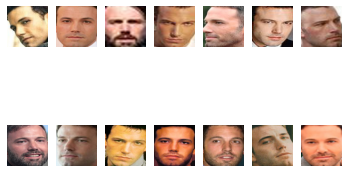

In [ ]:
# demonstrate face detection on 5 Celebrity Faces Dataset
from os import listdir
from PIL import Image
from numpy import asarray
from matplotlib import pyplot
from mtcnn.mtcnn import MTCNN
import tensorflow

# extract a single face from a given photograph
def extract_face(filename, required_size=(160, 160)):
	# load image from file
	image = Image.open(filename)
	# convert to RGB, if needed
	image = image.convert('RGB')
	# convert to array
	pixels = asarray(image)
	# create the detector, using default weights
	detector = MTCNN()
	# detect faces in the image
	results = detector.detect_faces(pixels)
	# extract the bounding box from the first face
	x1, y1, width, height = results[0]['box']
	# bug fix
	x1, y1 = abs(x1), abs(y1)
	x2, y2 = x1 + width, y1 + height
	# extract the face
	face = pixels[y1:y2, x1:x2]
	# resize pixels to the model size
	image = Image.fromarray(face)
	image = image.resize(required_size)
	face_array = asarray(image)
	return face_array

with tensorflow.device('/cpu:0'):
    # specify folder to plot
    folder = '5-celebrity-faces-dataset/train/ben_afflek/'
    i = 1
    # enumerate files
    for filename in listdir(folder):
        # path
        path = folder + filename
        # get face
        face = extract_face(path)
        print(i, face.shape)
        # plot
        pyplot.subplot(2, 7, i)
        pyplot.axis('off')
        pyplot.imshow(face)
        i += 1
    pyplot.show()

Next, we can extend this example to step over each subdirectory for a given dataset (e.g. ‘train‘ or ‘val‘), extract the faces, and prepare a dataset with the name as the output label for each detected face.<br>
The load_faces() function below will load all of the faces into a list for a given directory, e.g. ‘5-celebrity-faces-dataset/train/ben_afflek/‘.<br>

```Python
def load_faces(directory):
	faces = list()
	# enumerate files
	for filename in listdir(directory):
		# path
		path = directory + filename
		# get face
		face = extract_face(path)
		# store
		faces.append(face)
	return faces
```

Ta có thể sử dụng hàm load_face() để load tất cả dữ liệu khuôn mặt ứng với một subdirectory là 'train' và 'test', mỗi khuôn mặt có một nhãn, là tên của người nổi tiếng, chính là tên của subdirctory.<br>
Ta định nghía hàm load_dataset() có input là đường dẫn tới file dataset, detect các khuôn mặt trong từng subdirectory(celebrity), và gán nhãn cho các khuôn mặt tương ứng.<br>
Hàm trà về X,y là các NumPy array.<br>
```Python
# load a dataset that contains one subdir for each class that in turn contains images
def load_dataset(directory):
	X, y = list(), list()
	# enumerate folders, on per class
	for subdir in listdir(directory):
		# path
		path = directory + subdir + '/'
		# skip any files that might be in the dir
		if not isdir(path):
			continue
		# load all faces in the subdirectory
		faces = load_faces(path)
		# create labels
		labels = [subdir for _ in range(len(faces))]
		# summarize progress
		print('>loaded %d examples for class: %s' % (len(faces), subdir))
		# store
		X.extend(faces)
		y.extend(labels)
	return asarray(X), asarray(y)
```

Dùng hàm này cho 2 tập 'train' và 'test' load tất cả data, lưu chúng lại trong một compress Numpy array file thông qua hàm <a href = https://docs.scipy.org/doc/numpy/reference/generated/numpy.savez_compressed.html> savez_compressed() function</a>
```Python
# load train dataset
trainX, trainy = load_dataset('5-celebrity-faces-dataset/train/')
print(trainX.shape, trainy.shape)
# load test dataset
testX, testy = load_dataset('5-celebrity-faces-dataset/val/')
print(testX.shape, testy.shape)
# save arrays to one file in compressed format
savez_compressed('5-celebrity-faces-dataset.npz', trainX, trainy, testX, testy)
```

Kết hợp tất cả các code ở trên ta có được toàn bộ quy trình để detect khuôn mặt trong tập dataset

In [ ]:
# face detection for the 5 Celebrity Faces Dataset
from os import listdir
from os.path import isdir
from PIL import Image
from matplotlib import pyplot
from numpy import savez_compressed
from numpy import asarray
from mtcnn.mtcnn import MTCNN
import tensorflow

# extract a single face from a given photograph
def extract_face(filename, required_size=(160, 160)):
	# load image from file
	image = Image.open(filename)
	# convert to RGB, if needed
	image = image.convert('RGB')
	# convert to array
	pixels = asarray(image)
	# create the detector, using default weights
	detector = MTCNN()
	# detect faces in the image
	results = detector.detect_faces(pixels)
	# extract the bounding box from the first face
	x1, y1, width, height = results[0]['box']
	# bug fix
	x1, y1 = abs(x1), abs(y1)
	x2, y2 = x1 + width, y1 + height
	# extract the face
	face = pixels[y1:y2, x1:x2]
	# resize pixels to the model size
	image = Image.fromarray(face)
	image = image.resize(required_size)
	face_array = asarray(image)
	return face_array

# load images and extract faces for all images in a directory
def load_faces(directory):
	faces = list()
	# enumerate files
	for filename in listdir(directory):
		# path
		path = directory + filename
		# get face
		face = extract_face(path)
		# store
		faces.append(face)
	return faces

# load a dataset that contains one subdir for each class that in turn contains images
def load_dataset(directory):
	X, y = list(), list()
	# enumerate folders, on per class
	for subdir in listdir(directory):
		# path
		path = directory + subdir + '/'
		# skip any files that might be in the dir
		if not isdir(path):
			continue
		# load all faces in the subdirectory
		faces = load_faces(path)
		# create labels
		labels = [subdir for _ in range(len(faces))]
		# summarize progress
		print('>loaded %d examples for class: %s' % (len(faces), subdir))
		# store
		X.extend(faces)
		y.extend(labels)
	return asarray(X), asarray(y)

# load train dataset
with tensorflow.device('/cpu:0'):
    trainX, trainy = load_dataset('5-celebrity-faces-dataset/train/')
    print(trainX.shape, trainy.shape)
    # load test dataset
    testX, testy = load_dataset('5-celebrity-faces-dataset/val/')
    # save arrays to one file in compressed format
    savez_compressed('5-celebrity-faces-dataset.npz', trainX, trainy, testX, testy)

>loaded 14 examples for class: ben_afflek
>loaded 17 examples for class: elton_john
>loaded 21 examples for class: jerry_seinfeld
>loaded 19 examples for class: madonna
>loaded 22 examples for class: mindy_kaling
(93, 160, 160, 3) (93,)
>loaded 5 examples for class: ben_afflek
>loaded 5 examples for class: elton_john
>loaded 5 examples for class: jerry_seinfeld
>loaded 5 examples for class: madonna
>loaded 5 examples for class: mindy_kaling


Giờ ta đã có tập dataset sẵn sàng cho giai đoạn face recognition

### Tạo Face Embeddings

Tiếp theo ta sẽ đi tạo face embedding<br>
Face Embedding là một vector biễu diễn cho các đặc trưng được trích xuất ra từ khuôn mặt, thứ sau đó được dùng để đem đi so sánh với face embedding của khuôn mặt khác. Khoảng cách giữa 2 vector này càng gần thì nghĩa là 2 người này được xem như giống nhau, ngược lại là khác nhau.<br>
Classifier model sẽ sử dụng face embedding này như input và sẽ tiến hành định danh khuôn mặt của vector này.Ta dùng FaceNet model đề sinh face embeddings cho ảnh khuôn mặt.<br>
Ta sẽ tiến hành tính face embeddings cho toàn bộ tập data gồm 'train' và 'test'.<br>

```Python
# load the face dataset
data = load('5-celebrity-faces-dataset.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)```

Tiếp theo ta load FaceNet model để tiến hành tính face embeddings cho tập data.<br>

```Python
# load the facenet model
model = load_model('facenet_keras.h5')
print('Loaded Model')
```
Để dự đoán, trước tiên ảnh phải tương thích với điều kiện của FaceNet model này. Với bản hiện thực này của FaceNet đòi hỏi pixel image phải được chuẩn hoas.<br>

```Python
# scale pixel values
face_pixels = face_pixels.astype('float32')
# standardize pixel values across channels (global)
mean, std = face_pixels.mean(), face_pixels.std()
face_pixels = (face_pixels - mean) / std
```

Mô hình FaceNet này được hiện thực bằng Keras,do đó cần expand thêm một dims vào anhr<br>

```Python
# transform face into one sample
samples = expand_dims(face_pixels, axis=0)
```

Bây giờ thì có thể dùng model để thực hiện predict sinh face embedding được rồi :V<br>

```Python
# make prediction to get embedding
yhat = model.predict(samples)
# get embedding
embedding = yhat[0]
```

Hàm get_embedding() sẽ trả về một face embedding tương ứng cho một ành của một khuôn matwj<br>

```Python
# get the face embedding for one face
def get_embedding(model, face_pixels):
	# scale pixel values
	face_pixels = face_pixels.astype('float32')
	# standardize pixel values across channels (global)
	mean, std = face_pixels.mean(), face_pixels.std()
	face_pixels = (face_pixels - mean) / std
	# transform face into one sample
	samples = expand_dims(face_pixels, axis=0)
	# make prediction to get embedding
	yhat = model.predict(samples)
	return yhat[0]
```

Kết hợp tất cả các công đọan trên lại ta sẽ có một quy trình hoàn chỉnh để có được face embedding cho cả tập 'train' và 'test'<br>

In [ ]:
# calculate a face embedding for each face in the dataset using facenet
import tensorflow as tf
from numpy import load
from numpy import expand_dims
from numpy import asarray
from numpy import savez_compressed
from tensorflow.keras.models import load_model

# get the face embedding for one face
def get_embedding(model, face_pixels):
	# scale pixel values
	face_pixels = face_pixels.astype('float32')
	# standardize pixel values across channels (global)
	mean, std = face_pixels.mean(), face_pixels.std()
	face_pixels = (face_pixels - mean) / std
	# transform face into one sample
	samples = expand_dims(face_pixels, axis=0)
	# make prediction to get embedding
	yhat = model.predict(samples)
	return yhat[0]

with tf.device('/cpu:0'):
    # load the face dataset
    data = load('5-celebrity-faces-dataset.npz')
    trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
    print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)
    # load the facenet model
    model = load_model('facenet_keras.h5')
    print('Loaded Model')
    # convert each face in the train set to an embedding
    newTrainX = list()
    for face_pixels in trainX:
        embedding = get_embedding(model, face_pixels)
        newTrainX.append(embedding)
    newTrainX = asarray(newTrainX)
    print(newTrainX.shape)
    # convert each face in the test set to an embedding
    newTestX = list()
    for face_pixels in testX:
        embedding = get_embedding(model, face_pixels)
        newTestX.append(embedding)
    newTestX = asarray(newTestX)
    print(newTestX.shape)
    # save arrays to one file in compressed format
    savez_compressed('5-celebrity-faces-embeddings.npz', newTrainX, trainy, newTestX, testy)

Loaded:  (93, 160, 160, 3) (93,) (25, 160, 160, 3) (25,)
Loaded Model
(93, 128)
(25, 128)


Tập 'train' bây giờ trở thành một ma trận với 93 vector face embedding mỗi vector có 128 chiều, tập 'test' thì là 25 vector 128 chiều.<br>

### Tiến hành Face Classification

Trong phần này ta xây dựng model, để phân loại xem face embeddings có thuộc vào 1 trong 5 khuôn mặt của người nổi tiếng trong tập dataset hay không.<br>

```Python
# load dataset
data = load('5-celebrity-faces-embeddings.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Dataset: train=%d, test=%d' % (trainX.shape[0], testX.shape[0]))
```
Tiến hành load dataste face embeddings trước đó.

Trong thực tế sẽ tốt hơn nếu ta thực hiện chuẩn hóa Vector face embedding, tức là scaling chiều dài vector về 1, có thể được thực hiện dễ dàng bằng <a href = https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Normalizer.html>Normalizer class trrong scikit-learn</a>

```Python
# normalize input vectors
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)
```

Chuyển các nhãn đang ở dạng chuỗi sang integer

```Python
# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)
```

Người ta thường sử dụng Linear Support Vector Machine (SVM) khi làm việc với các đầu vào normalized face embedding. Điều này là do phương pháp này rất hiệu quả trong việc tách các vectơ  face embedding. Chúng ta có thể điều chỉnh một SVM tuyến tính với dữ liệu huấn luyện bằng cách sử dụng lớp SVC trong scikit-learn và đặt thuộc tính ‘kernel‘ thành ‘linear‘. Ta có thể muốn xác suất sau này khi đưa ra dự đoán, có thể được định cấu hình bằng cách đặt ‘probability‘ thành ‘True‘.<br>

```Python
# fit model
model = SVC(kernel='linear')
model.fit(trainX, trainy)
```

Tiếp theo, ta có thể đánh giá mô hình.

Điều này có thể đạt được bằng cách sử dụng mô hình phù hợp để đưa ra dự đoán cho từng ví dụ trong tập train và tập test và sau đó tính toán độ chính xác classification.

```Python
# predict
yhat_train = model.predict(trainX)
yhat_test = model.predict(testX)
# score
score_train = accuracy_score(trainy, yhat_train)
score_test = accuracy_score(testy, yhat_test)
# summarize
print('Accuracy: train=%.3f, test=%.3f' % (score_train*100, score_test*100))
```

Kết hợp tất cả những thứ này lại với nhau, hoàn chỉnh ví dụ về việc lắp một Linear SVM trên các face embedding cho Bộ dữ liệu 5 Celebrity Faces được liệt kê dưới đây.

In [21]:
# develop a classifier for the 5 Celebrity Faces Dataset
from numpy import load
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
# load dataset
data = load('5-celebrity-faces-embeddings.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Dataset: train=%d, test=%d' % (trainX.shape[0], testX.shape[0]))
# normalize input vectors
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)
# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)
# fit model
model = SVC(kernel='linear', probability=True)
model.fit(trainX, trainy)
# predict
yhat_train = model.predict(trainX)
yhat_test = model.predict(testX)
# score
score_train = accuracy_score(trainy, yhat_train)
score_test = accuracy_score(testy, yhat_test)
# summarize
print('Accuracy: train=%.3f, test=%.3f' % (score_train*100, score_test*100))

Dataset: train=93, test=25
Accuracy: train=100.000, test=100.000


Chúng ta có thể làm cho nó thú vị hơn bằng cách vẽ khuôn mặt ban đầu và dự đoán.

Đầu tiên, ta cần tải bộ dữ liệu khuôn mặt, cụ thể là các khuôn mặt trong bộ dữ liệu test. Chúng ta cũng có thể tải các bức ảnh gốc để làm cho nó thú vị hơn.

```Python
# load faces
data = load('5-celebrity-faces-dataset.npz')
testX_faces = data['arr_2']
```

Đầu tiên, chúng ta cần chọn một ví dụ ngẫu nhiên từ tập test, sau đó lấy embedding, face pixels, dự đoán lớp dự kiến và tên tương ứng cho lớp.

```Python
# test model on a random example from the test dataset
selection = choice([i for i in range(testX.shape[0])])
random_face_pixels = testX_faces[selection]
random_face_emb = testX[selection]
random_face_class = testy[selection]
random_face_name = out_encoder.inverse_transform([random_face_class])
```

Tiếp theo, chúng ta có thể sử dụng face embedding làm input để đưa ra dự đoán duy nhất với model phù hợp.

Chúng ta có thể dự đoán cả lớp số nguyên và xác suất dự đoán.

```Python
# prediction for the face
samples = expand_dims(random_face_emb, axis=0)
yhat_class = model.predict(samples)
yhat_prob = model.predict_proba(samples)
```

Sau đó chúng ta có thể lấy tên cho lớp số nguyên dự đoán và xác suất cho dự đoán này.

```Python
# get name
class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)
```

Chúng ta cũng có thể vẽ các face pixel cùng với tên và xác suất dự đoán.

```Python
# plot for fun
pyplot.imshow(random_face_pixels)
title = '%s (%.3f)' % (predict_names[0], class_probability)
pyplot.title(title)
pyplot.show()
```

Kết hợp lại với nhau, hoàn thành ví dụ để dự đoán danh tính cho một bức ảnh chưa từng thấy trong bộ dữ liệu thử nghiệm được liệt kê dưới đây.

Predicted: ben_afflek (71.023)
Expected: ben_afflek


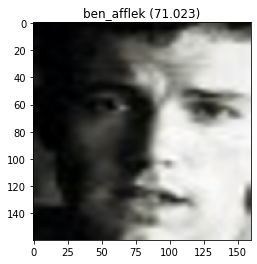

In [22]:
# develop a classifier for the 5 Celebrity Faces Dataset
from random import choice
from numpy import load
from numpy import expand_dims
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from matplotlib import pyplot
# load faces
data = load('5-celebrity-faces-dataset.npz')
testX_faces = data['arr_2']
# load face embeddings
data = load('5-celebrity-faces-embeddings.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
# normalize input vectors
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)
# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)
# fit model
model = SVC(kernel='linear', probability=True)
model.fit(trainX, trainy)
# test model on a random example from the test dataset
selection = choice([i for i in range(testX.shape[0])])
random_face_pixels = testX_faces[selection]
random_face_emb = testX[selection]
random_face_class = testy[selection]
random_face_name = out_encoder.inverse_transform([random_face_class])
# prediction for the face
samples = expand_dims(random_face_emb, axis=0)
yhat_class = model.predict(samples)
yhat_prob = model.predict_proba(samples)
# get name
class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)
print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
print('Expected: %s' % random_face_name[0])
# plot for fun
pyplot.imshow(random_face_pixels)
title = '%s (%.3f)' % (predict_names[0], class_probability)
pyplot.title(title)
pyplot.show()

## It's the end :>